In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.6 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 144.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 23.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [49]:
pip install --upgrade catboost

Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 2.3 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [71]:
pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 770.2 kB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [78]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  # for classification
from sklearn.metrics import roc_auc_score  # for classification
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [28]:
#Load data

data_test = pd.read_csv('test.csv')
data_train = pd.read_csv('train.csv')
X = data_train.copy()
del X['loan_status']
y = data_train.copy()
y = y['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [70]:
class_distribution = y.value_counts()
print(class_distribution)

loan_status
0    50295
1     8350
Name: count, dtype: int64


In [99]:
# Identify categorical features
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Get numerical features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a ColumnTransformer to apply One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),  # Apply One-Hot Encoding to categorical features
        ('num', 'passthrough', numerical_features)  # Keep numerical features as is
    ]
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Apply SMOTE to the processed training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

# Check the distribution of the classes after resampling
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_resampled).value_counts())

# Fit the CatBoost model with resampled data
model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, verbose=100, task_type='CPU')
model.fit(X_resampled, y_resampled)  # No cat_features since they are already encoded

# Transform the test data
X_test_processed = preprocessor.transform(X_test)

# Make predictions on the test set
y_pred = model.predict_proba(X_test_processed)[:, 1]  # Get probabilities for the positive class
roc = roc_auc_score(y_test, y_pred)  # Calculate ROC AUC score

print("ROC AUC score:", roc)

# Define the Optuna objective function
def objective(trial):
    # Hyperparameters to tune
    params = {
        "iterations": trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
        "task_type": 'CPU',
        "verbose": False
    }

    # Conditional addition of bagging_temperature based on bootstrap_type
    bootstrap_type = params["bootstrap_type"]
    if bootstrap_type == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)

    model = CatBoostClassifier(**params)
    
    # Fit the model
    model.fit(X_resampled, y_resampled, verbose=False)

    # Predict and calculate ROC AUC score
    y_pred = model.predict_proba(X_test_processed)[:, 1]  # Get probabilities for the positive class
    roc = roc_auc_score(y_test, y_pred)  # Calculate ROC AUC score

    return roc
    
# Create a study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best ROC AUC:", study.best_value)

# Fit the final model with the best parameters
best_params = study.best_params
model = CatBoostClassifier(**best_params)
model.fit(X_resampled, y_resampled)  # Fit with the best parameters

Before SMOTE: loan_status
0    40208
1     6708
Name: count, dtype: int64
After SMOTE: loan_status
0    40208
1    40208
Name: count, dtype: int64
0:	learn: 0.5612079	total: 67.1ms	remaining: 1m 7s
100:	learn: 0.1017546	total: 2.11s	remaining: 18.8s
200:	learn: 0.0895941	total: 4.29s	remaining: 17s
300:	learn: 0.0817869	total: 6.34s	remaining: 14.7s
400:	learn: 0.0761630	total: 8.36s	remaining: 12.5s
500:	learn: 0.0713920	total: 10.5s	remaining: 10.5s
600:	learn: 0.0673814	total: 12.7s	remaining: 8.41s
700:	learn: 0.0639125	total: 14.7s	remaining: 6.25s
800:	learn: 0.0606823	total: 16.8s	remaining: 4.18s
900:	learn: 0.0574787	total: 18.9s	remaining: 2.07s
999:	learn: 0.0545974	total: 20.9s	remaining: 0us


[I 2024-10-08 14:23:32,074] A new study created in memory with name: no-name-995732ce-9057-47c1-a15b-178fc384a659


ROC AUC score: 0.954488640665431


[I 2024-10-08 14:26:23,806] Trial 0 finished with value: 0.9260704103290411 and parameters: {'iterations': 1367, 'learning_rate': 0.012966410970796387, 'depth': 10, 'l2_leaf_reg': 0.010599543722313077, 'random_strength': 2.2932896049249676, 'od_type': 'Iter', 'od_wait': 23, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.69683483942114}. Best is trial 0 with value: 0.9260704103290411.
[I 2024-10-08 14:27:28,564] Trial 1 finished with value: 0.9226783016984874 and parameters: {'iterations': 919, 'learning_rate': 0.0006316135467820469, 'depth': 9, 'l2_leaf_reg': 5.590006310240311e-08, 'random_strength': 0.0009220589262488926, 'od_type': 'Iter', 'od_wait': 24, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.706384947750031}. Best is trial 0 with value: 0.9260704103290411.
[I 2024-10-08 14:27:42,897] Trial 2 finished with value: 0.8975166960959747 and parameters: {'iterations': 804, 'learning_rate': 0.0004615475170728565, 'depth': 4, 'l2_leaf_reg': 2.7482225703696047e-05, 'ra

Best parameters: {'iterations': 1665, 'learning_rate': 0.1101479814454797, 'depth': 4, 'l2_leaf_reg': 9.631819509387247, 'random_strength': 0.029588015270446587, 'od_type': 'Iter', 'od_wait': 50, 'bootstrap_type': 'Bernoulli'}
Best ROC AUC: 0.9557766433248763
0:	learn: 0.5554215	total: 19.8ms	remaining: 33s
1:	learn: 0.4671614	total: 37.5ms	remaining: 31.1s
2:	learn: 0.4068577	total: 60ms	remaining: 33.2s
3:	learn: 0.3693398	total: 78.4ms	remaining: 32.6s
4:	learn: 0.3389666	total: 99.1ms	remaining: 32.9s
5:	learn: 0.3076230	total: 117ms	remaining: 32.3s
6:	learn: 0.2913108	total: 135ms	remaining: 32s
7:	learn: 0.2718534	total: 151ms	remaining: 31.3s
8:	learn: 0.2536145	total: 171ms	remaining: 31.5s
9:	learn: 0.2362815	total: 190ms	remaining: 31.4s
10:	learn: 0.2244675	total: 211ms	remaining: 31.7s
11:	learn: 0.2123684	total: 229ms	remaining: 31.6s
12:	learn: 0.2020507	total: 253ms	remaining: 32.1s
13:	learn: 0.1932096	total: 275ms	remaining: 32.4s
14:	learn: 0.1901416	total: 290ms	rem

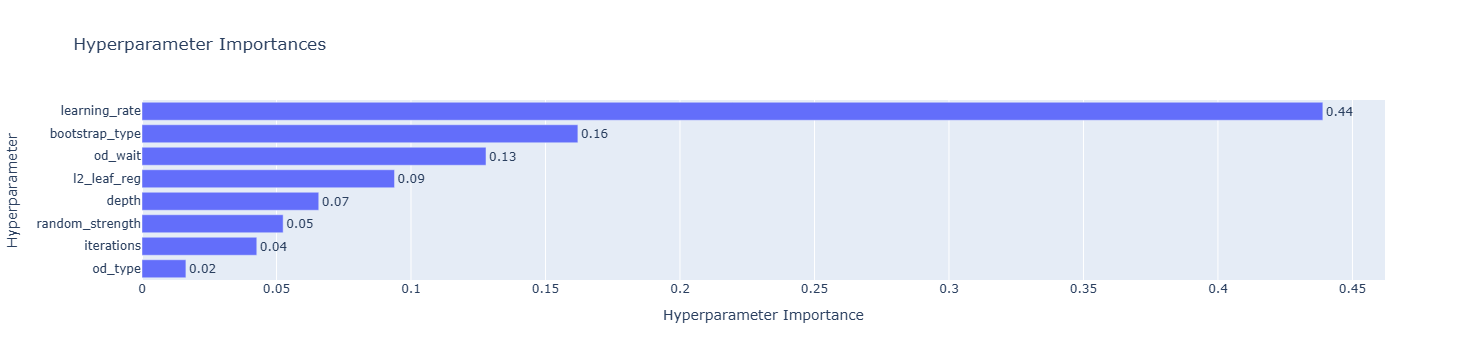

In [100]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show()

In [106]:
import numpy as np

# Get the feature importances from the model
importances = model.get_feature_importance()

# Get the feature names from the preprocessor
# This step is crucial as OneHotEncoder creates new feature names
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([cat_feature_names, numerical_features])

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                           Feature  Importance
25             loan_percent_income   10.031625
11                    loan_grade_B    7.670492
5            loan_intent_EDUCATION    7.276144
13                    loan_grade_D    7.158102
3       person_home_ownership_RENT    6.123327
10                    loan_grade_A    6.118055
21                   person_income    5.825297
7              loan_intent_MEDICAL    5.158468
8             loan_intent_PERSONAL    4.965420
6      loan_intent_HOMEIMPROVEMENT    4.468326
18     cb_person_default_on_file_Y    4.183031
0   person_home_ownership_MORTGAGE    4.037573
26      cb_person_cred_hist_length    4.027811
4    loan_intent_DEBTCONSOLIDATION    4.008677
12                    loan_grade_C    3.731190
22               person_emp_length    3.609573
17     cb_person_default_on_file_N    3.310854
9              loan_intent_VENTURE    2.646351
14                    loan_grade_E    1.585989
24                   loan_int_rate    1.220167
20           

In [107]:
print(best_params)

{'iterations': 1665, 'learning_rate': 0.1101479814454797, 'depth': 4, 'l2_leaf_reg': 9.631819509387247, 'random_strength': 0.029588015270446587, 'od_type': 'Iter', 'od_wait': 50, 'bootstrap_type': 'Bernoulli'}


In [ ]:
#Remove random_strength from tuning and refine search ranges

In [104]:
# Assuming 'data_test' is your test dataset
X_ = data_test.copy()

# Preprocess the test data
X_processed = preprocessor.transform(X_)  # Apply the same preprocessor as for training data

# Make predictions using the model
y_ = model.predict_proba(X_processed)[:, 1]  # Get probabilities for the positive class

# Compile solution
solution = {
    'id': X_['id'],  # Make sure 'id' column exists in data_test
    'loan_status': y_
}

# Create DataFrame and save to CSV
df = pd.DataFrame(solution)
df.to_csv('solution.csv', index=False)  # Add .csv extension to the output file